In [5]:
# ニュースの見出しから皮肉検出をおこなう
# https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection

In [38]:
# JSONからCSVへの変換スクリプト

import json
import csv

# JSONファイルの読み込み（1行ずつ処理）
data = []
with open('Sarcasm_Headlines_Dataset_v2.json', 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

# CSVファイルの書き出し
with open('Sarcasm_Headlines_Dataset_v2.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=['headline', 'is_sarcastic', 'article_link'])
    writer.writeheader()
    for item in data:
        writer.writerow(item)

print("変換完了：Sarcasm_Headlines_Dataset_v2.csv が作成されました。")



変換完了：Sarcasm_Headlines_Dataset_v2.csv が作成されました。


In [39]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# DataFrameで全ての列を表示する設定
pd.options.display.max_columns = None

In [40]:
# CSVファイルの読み込み
dataset_base = pd.read_csv('Sarcasm_Headlines_Dataset_v2.csv')

# データの確認
dataset_base.head()

,headline,is_sarcastic,article_link
0,thirtysomething scientists unveil doomsday clo...,1,https://www.theonion.com/thirtysomething-scien...
1,dem rep. totally nails why congress is falling...,0,https://www.huffingtonpost.com/entry/donna-edw...
2,eat your veggies: 9 deliciously different recipes,0,https://www.huffingtonpost.com/entry/eat-your-...
3,inclement weather prevents liar from getting t...,1,https://local.theonion.com/inclement-weather-p...
4,mother comes pretty close to using word 'strea...,1,https://www.theonion.com/mother-comes-pretty-c...


In [41]:
# 必要列の抜出し
dataset = dataset_base[['headline', 'is_sarcastic']]

# データの確認
dataset.head()

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


In [42]:
# 目的変数と説明変数に分割
Y = dataset['is_sarcastic']
X = dataset['headline']

print("Y=:", Y.shape, "X=:", X.shape)

Y=: (28619,) X=: (28619,)


In [43]:
# データの分割
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

In [44]:
# 形状を確認
print("Y_train=", Y_train.shape, ", X_train=", X_train.shape)
print("Y_valid=", Y_valid.shape, ", X_valid=", X_valid.shape)
print("Y_test=", Y_test.shape, ", X_test=", X_test.shape)

Y_train= (14023,) , X_train= (14023,)
Y_valid= (6010,) , X_valid= (6010,)
Y_test= (8586,) , X_test= (8586,)


In [45]:
# TextVectorizationレイヤーの定義
# テキストデータを数値データに変換する層
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=10000,
    output_mode='int',
    output_sequence_length=100
)

# TextVectorizationレイヤーに語彙を学習させる（X_train）
vectorize_layer.adapt(X_train)

In [47]:
# モデルの初期化

model = tf.keras.Sequential([
    # 入力層（文字列 → 整数列）
    tf.keras.layers.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,

    # 埋め込み層（単語をベクトルに変換）
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16), # 語彙サイズ（最大単語数）＝10000、16次元のベクトル

    # プーリング層（文全体の特徴を抽出）
    tf.keras.layers.GlobalAveragePooling1D(), # （単語のベクトルを文章のベクトルに変換）

    # 隠れ層
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    # 出力層（1:皮肉, 0:非皮肉）
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# モデルの構築
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
# モデルの構造を表示
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_7            │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 100, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,289 (626.13 KB)

 Trainable params: 160,289 (626.13 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
%%time
# 学習の実施
log = model.fit(X_train.values, Y_train.values, epochs=100, batch_size=64, verbose=True,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                            min_delta=0, patience=15,
                                                            verbose=1)],
                validation_data=(X_valid.values, Y_valid.values))

Epoch 1/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5215 - loss: 0.6917 - val_accuracy: 0.5135 - val_loss: 0.6916
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5310 - loss: 0.6882 - val_accuracy: 0.5135 - val_loss: 0.6842
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5951 - loss: 0.6682 - val_accuracy: 0.5499 - val_loss: 0.6456
Epoch 4/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7217 - loss: 0.5941 - val_accuracy: 0.7779 - val_loss: 0.5383
Epoch 5/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7776 - loss: 0.5023 - val_accuracy: 0.8078 - val_loss: 0.4653
Epoch 6/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8085 - loss: 0.4416 - val_accuracy: 0.8156 - val_loss: 0.4284
Epoch 7/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8296 - loss: 0.4052 - val_accuracy: 0.8309 - val_loss: 0.4026
Epoch 8/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8459 - loss: 0.3713 - val_accu

Text(0, 0.5, 'crossentropy')

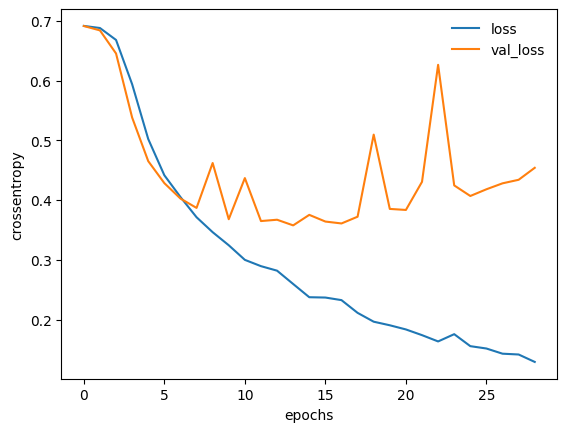

In [50]:
# グラフ表示
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False) # 凡例の表示
plt.xlabel("epochs")
plt.ylabel("crossentropy")

In [51]:
# テストデータで評価
Y_pred = model.predict(X_test.values)
Y_pred

269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[0.9916582 ],
       [0.31504986],
       [0.07146752],
       ...,
       [0.11198962],
       [0.93733   ],
       [0.9993012 ]], dtype=float32)

In [52]:
# 二値分類は予測結果の確率が0.5以下なら0,
# それより大きければ1となる計算で求める
Y_pred_ = (Y_pred > 0.5).astype("int32")
Y_pred_

array([[1],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [53]:
# モデルの評価
from sklearn.metrics import classification_report

print(classification_report(Y_test.values, Y_pred_))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      4560
           1       0.80      0.87      0.83      4026

    accuracy                           0.84      8586
   macro avg       0.84      0.84      0.84      8586
weighted avg       0.84      0.84      0.84      8586

